## VGG plus tuning final layer over 200,000 samples


In [1]:
#set up code ported from cs231n

In [1]:
%load_ext autoreload
%autoreload 2
from scipy.misc import imread, imresize
import numpy as np
import math
from scipy.misc import imread
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
from vgg import vgg16
import tensorflow as tf

%matplotlib inline

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [2]:
from data_utils import load_PROTEST

def get_PROTEST_data(batchno=0):
    # Load the data dictionary data
    # load_PROTEST(d_id=0,filename=None, batches=False, larger=False, features=False)
    data = load_PROTEST(batchno,None,True,True,True)
    
    X_train = data["X_train"].astype(np.dtype('float64'))
    y_train = data["y_train"].astype(np.dtype('float64'))

    return X_train, y_train



In [16]:
max_train_batches = 19

trainData = list()
ytrainData = list()
for i in range(max_train_batches):
    X_batch, y_batch = get_PROTEST_data(batchno=i)
    trainData.append(X_batch)
    ytrainData.append(y_batch)
    
X_train = np.concatenate(trainData, axis=0)
y_train = np.concatenate(ytrainData, axis=0)

print(X_train.shape)
print(y_train.shape)

KeyboardInterrupt: 

In [7]:
from data_utils import load_TARGET

## Retrieve the target data
def get_TARGET_data(mean_image=None):

    # Load the data dictionary data
    data = load_TARGET(True,True)
    
    X_target = data["X_target"].astype(np.dtype('float64'))
    y_target = data["y_target"].astype(np.dtype('float64'))    

    return X_target, y_target


# Invoke the above function to get our data.
X_target, y_target = get_TARGET_data()
print('Target data shape: ', X_target.shape)
print('Target labels shape: ', y_target.shape)

Target data shape:  (4408, 4096)
Target labels shape:  (4408,)


In [8]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    print(train_indicies[:15])
    
    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    results = list()
    
    all_losses = list()
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            all_losses.append(loss*actual_batch_size)
            
            batch_results = np.stack((corr.astype(int),yd[idx]))
            results.append(batch_results)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses,'r')
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
            
            
    plt.plot(all_losses,'r')
    plt.grid(True)
    plt.title('Train Loss Curve')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.show()
    
    
    return total_loss,total_correct,np.concatenate(results, axis=1)

In [9]:
def linear_model(X,y,is_training):
    X_flat = tf.contrib.layers.flatten(inputs=X)
    
    y_out = tf.contrib.layers.fully_connected(inputs=X_flat,num_outputs=2,biases_initializer=tf.zeros_initializer(),
                                activation_fn=None, trainable=True)
        
    return y_out
    
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 4096])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = linear_model(X,y,is_training)

## L2 Regularization
weights = [x for x in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) if 'weights' in x.name]
regularizer = sum([tf.nn.l2_loss(w) for w in weights])
reg = 5e-2
##


total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_out,labels=y)
mean_loss = tf.reduce_mean(total_loss + reg*regularizer)
optimizer = tf.train.AdamOptimizer(5e-4)
train_step = optimizer.minimize(mean_loss)

Training
[31941 36945 35309 24471 14261 34360 27023 37639 15054   323 24593 36717
 30657 37288 10471]
Iteration 0: with minibatch training loss = 1.2 and accuracy of 0.48
Iteration 50: with minibatch training loss = 0.539 and accuracy of 0.83
Iteration 100: with minibatch training loss = 0.407 and accuracy of 0.88
Iteration 150: with minibatch training loss = 0.281 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.347 and accuracy of 0.89
Iteration 250: with minibatch training loss = 0.374 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.339 and accuracy of 0.86
Iteration 350: with minibatch training loss = 0.482 and accuracy of 0.81
Iteration 400: with minibatch training loss = 0.427 and accuracy of 0.88
Iteration 450: with minibatch training loss = 0.301 and accuracy of 0.88
Iteration 500: with minibatch training loss = 0.467 and accuracy of 0.81
Iteration 550: with minibatch training loss = 0.339 and accuracy of 0.91
Iteration 600: with minibat

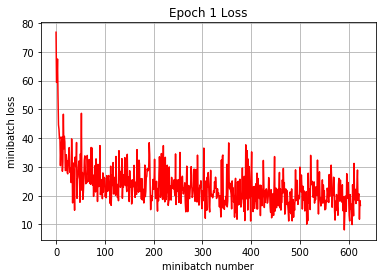

Iteration 650: with minibatch training loss = 0.363 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.197 and accuracy of 0.95
Iteration 750: with minibatch training loss = 0.317 and accuracy of 0.89
Iteration 800: with minibatch training loss = 0.22 and accuracy of 0.91
Iteration 850: with minibatch training loss = 0.234 and accuracy of 0.92
Iteration 900: with minibatch training loss = 0.278 and accuracy of 0.88
Iteration 950: with minibatch training loss = 0.308 and accuracy of 0.86
Iteration 1000: with minibatch training loss = 0.294 and accuracy of 0.92
Iteration 1050: with minibatch training loss = 0.447 and accuracy of 0.89
Iteration 1100: with minibatch training loss = 0.236 and accuracy of 0.92
Iteration 1150: with minibatch training loss = 0.328 and accuracy of 0.92
Iteration 1200: with minibatch training loss = 0.286 and accuracy of 0.91
Epoch 2, Overall loss = 0.285 and accuracy of 0.899


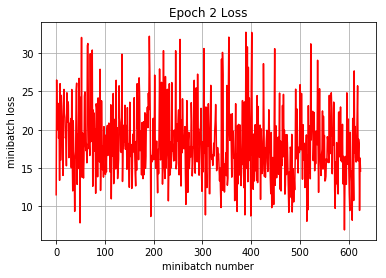

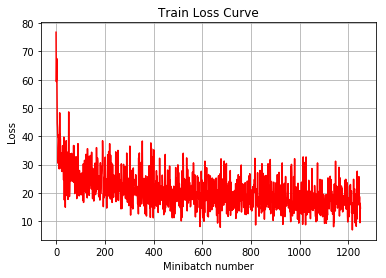

In [10]:
num_epochs = 5
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Training')
_,_,_, = run_model(sess,y_out,mean_loss,X_train,y_train,num_epochs,64,50,train_step,True)

In [11]:
#num_protests
#first axis is boolean if prediction was correct
#second axis of results_arr is the true classes
#for target_sample in range(results_arr.shape[1]):
def get_stats(results_arr):
    #results_arr = np.concatenate(results, axis=1)
    num_samples = results_arr.shape[1]
    tp = np.sum(np.prod(results_arr, axis=0))
    num_protests = np.sum(results_arr, axis=1)[1]

    print("Recall: %f"%(tp/num_protests))
    temp = (np.sum((results_arr*-1),axis=0)+1)
    fp = np.sum(temp[temp>0])
    print("Precision: %f"%(tp/(tp+fp)))

Training
[29370 34512 31975 12478 26546 17047 32536 32906  1730  9130 31960  1424
 29198  7594 38886]
Epoch 1, Overall loss = 0.255 and accuracy of 0.91


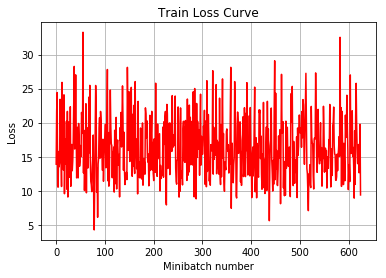

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]]
Recall: 0.925700
Precision: 0.897170


In [12]:
print('Training')
_,_,results = run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print(results[:,:15])
get_stats(results)

Validation
[3393 1733 8554 1096 9106 5308 3985 3424 4395 2027 6141 9534 1628 5931 5383]
Epoch 1, Overall loss = 0.273 and accuracy of 0.9


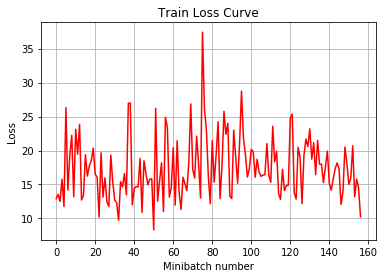

[[ 1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.]]
Recall: 0.916600
Precision: 0.886460


In [13]:
#use max_train_batches indexed batch as the validation set

X_val, y_val = get_PROTEST_data(batchno=max_train_batches)
print('Validation')
_,_,results = run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print(results[:,:15])
get_stats(results)

Target
[ 787 2826 1971 2162  219 3878 3665 3376 3269   91 1902 3022  862 3886 3846]
Epoch 1, Overall loss = 1.19 and accuracy of 0.588


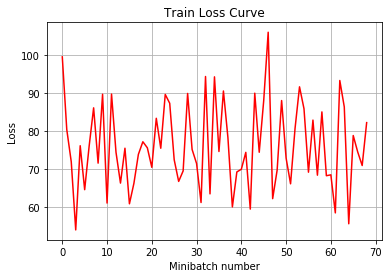

[[ 1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Recall: 0.809892
Precision: 0.236249


In [15]:
print('Target')
_,_,results = run_model(sess,y_out,mean_loss,X_target,y_target,1,64)
print(results[:,:15])
get_stats(results)